## **Load in data**

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pylab
import dateutil.parser as dp
from sklearn import preprocessing
from scipy.optimize import minimize

from GP import * 
from vis import *



data_url = 'http://www.robots.ox.ac.uk/~mosb/teaching/AIMS_CDT/sotonmet.txt'
data = pd.read_csv(data_url)

print(data.columns)

# Time in days since first reading
t = data['Reading Date and Time (ISO)']
t = [int(dp.parse(x).strftime('%s')) for x in t]
t = np.array([float(x - t[0])/86400 for x in t]).reshape(-1,1)

# Training and test data
y = data['Tide height (m)']
ytrue = data['True tide height (m)']

# Remove missing data points
data_train = [(t[i], y[i]) for i in range(len(t)) if not np.isnan(y[i])]
data_test = [(t[i], ytrue[i]) for i in range(len(t)) if not np.isnan(ytrue[i])]
t, y = [x[0] for x in data_train], [x[1] for x in data_train]
ttrue, ytrue = np.array([x[0] for x in data_test]).reshape(-1,1), [x[1] for x in data_test]

# Normalise both datasetts
mean, stdev = np.mean(y), np.std(y)
y = np.array([(yi - mean) / stdev for yi in y]).reshape(-1,1)
ytrue = np.array([(yi - mean) / stdev for yi in ytrue]).reshape(-1,1)

# Outputs are t, y, ttrue, ytrue


Index(['Update Date and Time (ISO)', 'Update Duration (ms)',
       'Reading Date and Time (ISO)', 'Air pressure (mb)',
       'Air temperature (C)', 'Tide height (m)', 'Wind direction (deg)',
       'Wind gust speed (kn)', 'Wind speed (kn)', 'True air temperature (C)',
       'True tide height (m)', 'Independent tide height prediction (m)',
       'Independent tide height deviation (m)',
       'Dependent tide height prediction (m)',
       'Dependent tide height deviation (m)',
       'Independent air temperature prediction (C)',
       'Independent air temperature deviation (C)',
       'Dependent air temperature prediction (C)',
       'Dependent air temperature deviation (C)'],
      dtype='object')


## **Initial Test**

Hyperparameters chosen manually to provide a reasonable fit to the data, using a summed RBF kernel and periodic kernel.


[[2.         1.96576859 1.92147796 ... 0.96854181 0.98917637 0.99911178]
 [1.96576859 2.         1.96576859 ... 0.93791671 0.96854181 0.98917637]
 [1.92147796 1.96576859 2.         ... 0.89833068 0.93791671 0.96854181]
 ...
 [0.96854181 0.93791671 0.89833068 ... 2.         1.96576859 1.92147796]
 [0.98917637 0.96854181 0.93791671 ... 1.96576859 2.         1.96576859]
 [0.99911178 0.98917637 0.96854181 ... 1.92147796 1.96576859 2.        ]]
Log marginal likelihood: 330.45385817917975
RMSE:  37.98008878890237





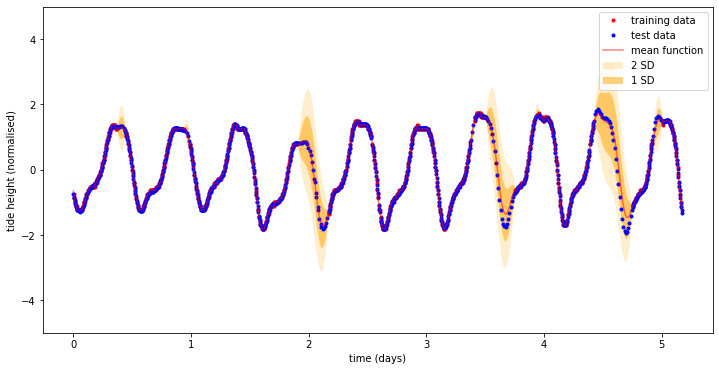

In [2]:

# Input data for GP
X = t
Y = y 
# Xs = np.linspace(-1, 6, 500).reshape(-1,1) 
Xs = ttrue

# Initial guess for model parameters
sigma_rbf = 1.0
L_rbf = 0.2

sigma_per = 1
L_per = 0.4
p_per = 0.5175

jitter = 0.01

# Parameters from optimizer result
# jitter, sigma_rbf, L_rbf, sigma_per, L_per, p_per = 0.02313429, -0.32364286,  0.46129201,  0.62726026,  0.80954964,  0.51560234

# Build the kernel function
params = [jitter, sigma_rbf, L_rbf, sigma_per, L_per, p_per]
kernel = buildKernel(params)

# Mean and covariance functions
mu = np.zeros(len(X))
K = kernel(X, X)

# Posterior predictive distribution
mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

# Compute RMSE
RMSE = getRMSE(mu, ytrue)

# Printouts
print("Log marginal likelihood:", LML)
print('RMSE: ', RMSE)

# Visualisation
plotTides(Xs, mu, sigma, t, y, ttrue, ytrue)



## Optimisation of Log Marginal Likelihood


[[2.         1.96576859 1.92147796 ... 0.96854181 0.98917637 0.99911178]
 [1.96576859 2.         1.96576859 ... 0.93791671 0.96854181 0.98917637]
 [1.92147796 1.96576859 2.         ... 0.89833068 0.93791671 0.96854181]
 ...
 [0.96854181 0.93791671 0.89833068 ... 2.         1.96576859 1.92147796]
 [0.98917637 0.96854181 0.93791671 ... 1.96576859 2.         1.96576859]
 [0.99911178 0.98917637 0.96854181 ... 1.92147796 1.96576859 2.        ]]
LML: 330.45385817917975
[[2.         1.96576859 1.92147796 ... 0.96854181 0.98917637 0.99911178]
 [1.96576859 2.         1.96576859 ... 0.93791671 0.96854181 0.98917637]
 [1.92147796 1.96576859 2.         ... 0.89833068 0.93791671 0.96854181]
 ...
 [0.96854181 0.93791671 0.89833068 ... 2.         1.96576859 1.92147796]
 [0.98917637 0.96854181 0.93791671 ... 1.96576859 2.         1.96576859]
 [0.99911178 0.98917637 0.96854181 ... 1.92147796 1.96576859 2.        ]]
LML: 330.4538529607697
[[2.00000003 1.96576862 1.92147799 ... 0.96854181 0.98917637 0.99

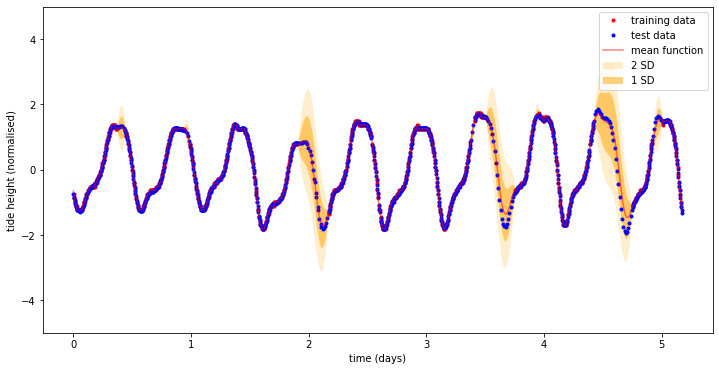

In [3]:
# Input data for GP
X = t
Y = y 
# Xs = np.linspace(-1, 6, 500).reshape(-1,1) 
Xs = ttrue

# Initial guess for model parameters
jitter = 0.01

sigma_rbf = 1.0 # RBF kernel
L_rbf = 0.2

sigma_per = 1.  # periodic kernel
L_per = 0.4
p_per = 0.5175

init_guess = [jitter, sigma_rbf, L_rbf, sigma_per, L_per, p_per]

max_iter = 0
result = minimize(
    optimizerFunction, 
    init_guess, 
    args=(X, Y, Xs), 
    method='BFGS', 
    tol=0.01,
    options={"maxiter":max_iter, "disp":True})
# optimize.minimize(

print("initial guess: ", init_guess)
    
print("final parameters: ", end='')
print(*result.x, sep=',')

# Build the kernel function
params = result.x
kernel = buildKernel(params)

# Mean and covariance functions
mu = np.zeros(len(X))
K = kernel(X, X)

# Posterior predictive distribution
jitter = params[0]
mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)

# Compute RMSE
RMSE = getRMSE(mu, ytrue)

# Printouts
print("Log marginal likelihood:", LML)
print('RMSE: ', RMSE)

# Visualisation
plotTides(Xs, mu, sigma, t, y, ttrue, ytrue)

## Look-ahead experiments

We choose some lookahead time $\delta_t$. Then, for each available data point at time $t$ in the ground truth dataset, we try to predict its value using only data from before time $t - \delta_t$.

[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
Finished iteration 10 of 1258
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
Finished iteration 20 of 1258
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
Finished iteration 30 of 1258
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
Finished iteration 40 of 1258
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
Finished iteration 50 of 1258
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
Finished iteration 60 of 1258
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
Finished iteration 70 of 1258
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
Finished iteration 80 of 1258
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
Finished iteration 90 of 1258
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
[[2.]]
Finished iteration 100 of 1258
[[2.]]
[[2.]]
[[2.]]

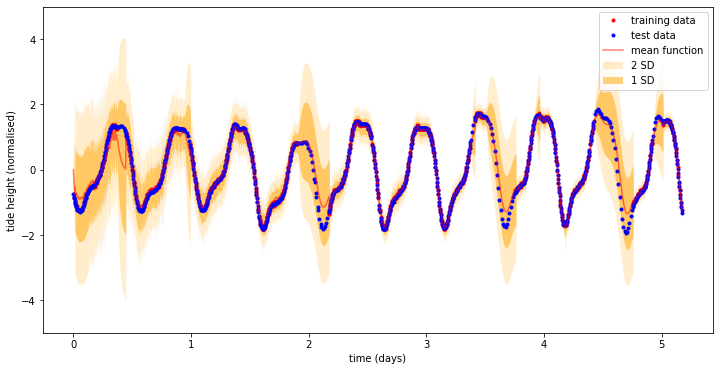

In [4]:
# Lookahead period in minutes
lookahead = 60 # 3*24*60
dt = lookahead / (60 * 24) # days

# Total available data
pts = len(ttrue)

# Start predicting from the nth datapoint onwards
first = 1

tvals = ttrue[first-1:]
n = len(tvals)
yvals = np.zeros(n)
muvals = np.zeros(n)
sigmavals = np.eye(n)
Xsvals = np.zeros(n)

pskip = 10

for i in range(first-1, pts):

    iter = i - first + 1
    if iter > 0 and iter % pskip == 0:
        print("Finished iteration", i-first+1, "of", pts-first+1)
    
    target_time = ttrue[i]

    j = 0
    while j < len(t) and t[j] + dt < target_time:
        j += 1

    # Too early in dataset to look ahead
    if ttrue[i] < dt or j == 0: 
        continue 

    # Extract data used for lookahead
    X = t[:j]
    Y = y[:j]

    Xs = np.array([target_time])

    params = [0.1, 1.0, 0.2, 1.0, 0.4, 0.5175]
    kernel = buildKernel(params)

    # Posterior predictive distribution
    jitter = params[0]
    mu, sigma, LML = getPosteriorPredictive(X, Y, Xs, kernel, jitter)
    # print(sigma)

    # Sanity checking
     # jj = 0
    # while t[jj] < target_time:
    #     jj += 1

   # print(t[jj], target_time) # should be always equal
    # print("Time lookahead gap (hrs): ", 24 * (target_time - X[-1])) # check lookahead time
    # print("Compare:", mu, ytrue[jj])

    # Store variables for plotting
    ii = i - first + 1
    muvals[ii] = mu
    sigmavals[ii,ii] = sigma
    Xsvals[ii] = Xs


# Visualisation
plotTides(Xsvals, muvals, sigmavals, t, y, ttrue, ytrue)

